In [1]:
import ModelManager as mm_mod
import config_defaults as cd
from importlib import reload
import numpy as np
import matplotlib.pyplot as plt
import time
import logging

from tqdm import tqdm_notebook as tqdm


%matplotlib inline
%load_ext autotime

### Initializing the Model and Data pipes

In [2]:
reload(mm_mod)
reload(cd)
logger = logging.getLogger('__main__')
logger.setLevel(logging.WARNING)

time: 6.28 ms


In [3]:
mm = mm_mod.ModelManager()
mm.hparams
# mm = mm_mod.ModelManager(hparams=None)

{'LR': 0.01,
 'NEPOCH': 10,
 'BATCH_SIZE': 32,
 'NGRAM_SIZE': 2,
 'VOC_SIZE': 10000,
 'EMBEDDING_DIM': 100,
 'NGRAM_MODE': 'naive',
 'VAL_SIZE': 5000,
 'OPTIMIZER': torch.optim.adam.Adam,
 'VAL_FREQ': 4,
 'REMOVE_STOP_WORDS': True,
 'REMOVE_PUNC': True,
 'EARLY_STOP': True,
 'EARLY_STOP_LOOKBACK': 4,
 'EARLY_STOP_MIN_IMPROVE': 0.01}

time: 2.39 ms


## extracting the ngrams for n = 1, 2, 3, 4 with both naive and spacy

In [5]:
"""
n_list = (1, 2, 3, 4)
mode_list = ('naive', 'spacy')

for n in n_list:
    for mode in mode_list:
        print("extracting n-grams for: n=%s, mode=%s" % (n, mode))
        param_overrides = {'NGRAM_MODE': mode,
                           'NGRAM_SIZE': n}
        mm = mm_mod.ModelManager(hparams=param_overrides)
        mm.load_data()
"""

'\nn_list = (1, 2, 3, 4)\nmode_list = (\'naive\', \'spacy\')\n\nfor n in n_list:\n    for mode in mode_list:\n        print("extracting n-grams for: n=%s, mode=%s" % (n, mode))\n        param_overrides = {\'NGRAM_MODE\': mode,\n                           \'NGRAM_SIZE\': n}\n        mm = mm_mod.ModelManager(hparams=param_overrides)\n        mm.load_data()\n'

time: 10.4 ms


### Trying to find a good LR

In [7]:
lr_list_exp_neg = np.arange(1,6)
lr_list_neg = 1 / np.power(10, lr_list_exp_neg)
lr_list_exp_pos = np.arange(0,3)
lr_list_pos = np.power(10, lr_list_exp_pos)

lr_list = np.append(lr_list_neg, lr_list_pos)
lr_list.sort()
print(lr_list)

[1.e-05 1.e-04 1.e-03 1.e-02 1.e-01 1.e+00 1.e+01 1.e+02]
time: 6.11 ms


In [10]:
# training all of these through 1 epoch and seeing results
mm.load_data()
mm.data_to_pipe()

mm.res_df = None  # reset the results dataframe
for cur_lr in lr_list:
    # overriding some hyperparameters
    print("training for lr = %s" % cur_lr)
    param_overrides = {'LR': cur_lr,
                       'EARLY_STOP': False}
    mm.hparams.update(param_overrides)
    mm.train(epoch_override=1, reload_data=False)  
display(mm.res_df)

training for lr = 1e-05
training for lr = 0.0001
training for lr = 0.001
training for lr = 0.01
training for lr = 0.1
training for lr = 1.0
training for lr = 10.0
training for lr = 100.0


,initial_val_acc,epoch1_val_acc,epoch2_val_acc,epoch3_val_acc,final_val_acc,training_time,total_data_iterated,early_stopped,pct_unk_train,pct_unk_val,...,EMBEDDING_DIM,NGRAM_MODE,VAL_SIZE,OPTIMIZER,VAL_FREQ,REMOVE_STOP_WORDS,REMOVE_PUNC,EARLY_STOP,EARLY_STOP_LOOKBACK,EARLY_STOP_MIN_IMPROVE
1,,,,,47.92,12.25,20000,False,0.60734,0.610612,...,100,naive,5000,<class 'torch.optim.adam.Adam'>,4,True,True,False,4,0.01
2,,,,,57.00,9.96,20000,False,0.60734,0.610612,...,100,naive,5000,<class 'torch.optim.adam.Adam'>,4,True,True,False,4,0.01
3,,,,,78.86,10.09,20000,False,0.60734,0.610612,...,100,naive,5000,<class 'torch.optim.adam.Adam'>,4,True,True,False,4,0.01
4,,,,,86.94,11.77,20000,False,0.60734,0.610612,...,100,naive,5000,<class 'torch.optim.adam.Adam'>,4,True,True,False,4,0.01
5,,,,,84.98,10.21,20000,False,0.60734,0.610612,...,100,naive,5000,<class 'torch.optim.adam.Adam'>,4,True,True,False,4,0.01
6,,,,,83.38,10.49,20000,False,0.60734,0.610612,...,100,naive,5000,<class 'torch.optim.adam.Adam'>,4,True,True,False,4,0.01
7,,,,,80.94,13.41,20000,False,0.60734,0.610612,...,100,naive,5000,<class 'torch.optim.adam.Adam'>,4,True,True,False,4,0.01
8,,,,,75.82,10.35,20000,False,0.60734,0.610612,...,100,naive,5000,<class 'torch.optim.adam.Adam'>,4,True,True,False,4,0.01
9,,,,,49.30,12.38,20000,False,0.60734,0.610612,...,100,naive,5000,<class 'torch.optim.adam.Adam'>,4,True,True,False,4,0.01
10,,,,,57.92,12.31,20000,False,0.60734,0.610612,...,100,naive,5000,<class 'torch.optim.adam.Adam'>,4,True,True,False,4,0.01


time: 1min 45s


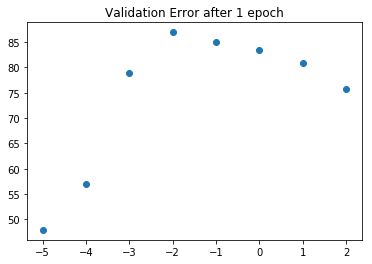

time: 134 ms


In [22]:
plt.scatter(np.log10(mm.res_df['LR']), mm.res_df['final_val_acc'])
plt.title('Validation Error after 1 epoch')
plt.show()

In [24]:
mm.save_results()

2018-10-03 18:37:56,415 __main__     INFO     results saved to ./results/res_df.p
time: 5.92 ms


### for each ngram param, find the right vocabulary size:

In [25]:
reload(mm_mod)
logger.setLevel(logging.WARNING)
voc_sizes = np.arange(1, 9) * 10000
n_list = (1, 2, 3, 4)
mode_list = ('naive', 'spacy')

for n in n_list:
    for mode in mode_list:
        for voc_size in voc_sizes:
            start_time = time.time()
            print("training models for: n=%s, mode=%s, voc_size=%s" % (n, mode, voc_size))
            param_overrides = {'NGRAM_MODE': mode,
                               'NGRAM_SIZE': n,
                               'VOC_SIZE': voc_size}
            mm = mm_mod.ModelManager(hparams=param_overrides, res_name='vocab_explore.p')
            mm.train()
            print("Final Validation Acc = %s (train time: %.1fs)\n" % (mm.validation_acc_history[-1], 
                                                                  time.time() - start_time))
    
            mm.save_results()

training models for: n=1, mode=naive, voc_size=10000
Final Validation Acc = 86.72 (train time: 18.8s)

training models for: n=1, mode=naive, voc_size=20000
Final Validation Acc = 87.54 (train time: 27.2s)

training models for: n=1, mode=naive, voc_size=30000
Final Validation Acc = 87.54 (train time: 31.7s)

training models for: n=1, mode=naive, voc_size=40000
Final Validation Acc = 86.94 (train time: 41.6s)

training models for: n=1, mode=naive, voc_size=50000
Final Validation Acc = 87.78 (train time: 47.7s)

training models for: n=1, mode=naive, voc_size=60000
Final Validation Acc = 87.5 (train time: 48.7s)

training models for: n=1, mode=naive, voc_size=70000
Final Validation Acc = 87.62 (train time: 56.2s)

training models for: n=1, mode=naive, voc_size=80000
Final Validation Acc = 87.14 (train time: 62.3s)

training models for: n=1, mode=spacy, voc_size=10000
Final Validation Acc = 87.1 (train time: 19.3s)

training models for: n=1, mode=spacy, voc_size=20000
Final Validation Acc =

### Extra vocabulary - for spacy ngram =4, the upper tail hasn't been fully explored

In [16]:
voc_sizes = np.arange(9, 15) * 10000
for voc_size in voc_sizes:
    start_time = time.time()
    print("training models for: n=4, mode=spacy, voc_size=%s" % (voc_size))
    param_overrides = {'NGRAM_MODE': 'spacy',
                       'NGRAM_SIZE': 4,
                       'VOC_SIZE': voc_size}
    mm = mm_mod.ModelManager(hparams=param_overrides, res_name='voc_additional.p')
    mm.train()
    print("Final Validation Acc = %s (train time: %.1fs)\n" % (mm.validation_acc_history[-1], 
                                                          time.time() - start_time))

    mm.save_results()

training models for: n=4, mode=spacy, voc_size=90000
Final Validation Acc = 89.72 (train time: 164.1s)

training models for: n=4, mode=spacy, voc_size=100000
Final Validation Acc = 89.4 (train time: 163.6s)

training models for: n=4, mode=spacy, voc_size=110000
Final Validation Acc = 89.4 (train time: 138.6s)

training models for: n=4, mode=spacy, voc_size=120000
Final Validation Acc = 89.56 (train time: 171.7s)

training models for: n=4, mode=spacy, voc_size=130000
Final Validation Acc = 89.86 (train time: 147.3s)

training models for: n=4, mode=spacy, voc_size=140000
Final Validation Acc = 89.56 (train time: 178.0s)

time: 16min 3s


In [20]:
voc_sizes = np.arange(3, 11) * 100000
voc_sizes

array([ 300000,  400000,  500000,  600000,  700000,  800000,  900000,
       1000000])

time: 3.24 ms


### What if we tried even larger vocabsizes?

In [ ]:
voc_sizes = np.arange(3, 11) * 100000
for voc_size in voc_sizes:
    start_time = time.time()
    print("training models for: n=4, mode=spacy, voc_size=%s" % (voc_size))
    param_overrides = {'NGRAM_MODE': 'spacy',
                       'NGRAM_SIZE': 4,
                       'VOC_SIZE': voc_size}
    mm = mm_mod.ModelManager(hparams=param_overrides, res_name='voc_additional.p')
    mm.train()
    print("Final Validation Acc = %s (train time: %.1fs)\n" % (mm.validation_acc_history[-1], 
                                                          time.time() - start_time))

    mm.save_results()

training models for: n=4, mode=spacy, voc_size=300000
Final Validation Acc = 89.78 (train time: 316.7s)

training models for: n=4, mode=spacy, voc_size=400000
Final Validation Acc = 90.0 (train time: 857.0s)

training models for: n=4, mode=spacy, voc_size=500000
Final Validation Acc = 90.08 (train time: 867.7s)

training models for: n=4, mode=spacy, voc_size=600000
Final Validation Acc = 89.58 (train time: 668.7s)

training models for: n=4, mode=spacy, voc_size=700000


### Embedding size

In [27]:
emb_dims = np.arange(2, 15) * 50
emb_dims

array([100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700])

time: 2.83 ms


In [29]:
reload(mm_mod)
logger.setLevel(logging.WARNING)
voc_sizes = np.arange(2, 13) * 10000
emb_dims = np.arange(1, 15) * 50

for emb_dim in emb_dims:
    for voc_size in voc_sizes:
        start_time = time.time()
        print("training models for: emb_dim=%s, voc_size=%s" % (emb_dim, voc_size))
        param_overrides = {'VOC_SIZE': voc_size,
                           'NGRAM_MODE':'spacy',
                           'EMBEDDING_DIM':emb_dim}
        mm = mm_mod.ModelManager(hparams=param_overrides, res_name='embdim.p')
        mm.train()
        print("Final Validation Acc = %s (train time: %.1fs)\n" % (mm.validation_acc_history[-1], 
                                                              time.time() - start_time))

        mm.save_results()

training models for: emb_dim=50, voc_size=20000
Final Validation Acc = 88.6 (train time: 26.7s)

training models for: emb_dim=50, voc_size=30000
Final Validation Acc = 88.98 (train time: 31.1s)

training models for: emb_dim=50, voc_size=40000
Final Validation Acc = 89.24 (train time: 37.2s)

training models for: emb_dim=50, voc_size=50000
Final Validation Acc = 89.0 (train time: 49.3s)

training models for: emb_dim=50, voc_size=60000
Final Validation Acc = 89.3 (train time: 49.7s)

training models for: emb_dim=50, voc_size=70000
Final Validation Acc = 88.9 (train time: 43.5s)

training models for: emb_dim=50, voc_size=80000
Final Validation Acc = 89.24 (train time: 44.3s)

training models for: emb_dim=50, voc_size=90000
Final Validation Acc = 89.14 (train time: 51.2s)

training models for: emb_dim=50, voc_size=100000
Final Validation Acc = 89.28 (train time: 53.3s)

training models for: emb_dim=50, voc_size=110000
Final Validation Acc = 89.3 (train time: 53.0s)

training models for: em

Final Validation Acc = 88.38 (train time: 221.1s)

training models for: emb_dim=400, voc_size=80000
Final Validation Acc = 88.26 (train time: 229.0s)

training models for: emb_dim=400, voc_size=90000
Final Validation Acc = 88.76 (train time: 271.9s)

training models for: emb_dim=400, voc_size=100000
Final Validation Acc = 88.58 (train time: 297.1s)

training models for: emb_dim=400, voc_size=110000
Final Validation Acc = 88.98 (train time: 353.4s)

training models for: emb_dim=400, voc_size=120000
Final Validation Acc = 88.8 (train time: 349.6s)

training models for: emb_dim=450, voc_size=20000
Final Validation Acc = 88.44 (train time: 106.5s)

training models for: emb_dim=450, voc_size=30000
Final Validation Acc = 87.92 (train time: 131.1s)

training models for: emb_dim=450, voc_size=40000
Final Validation Acc = 88.5 (train time: 151.6s)

training models for: emb_dim=450, voc_size=50000
Final Validation Acc = 88.54 (train time: 176.5s)

training models for: emb_dim=450, voc_size=60000

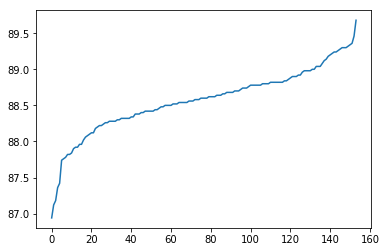

time: 62 ms


In [33]:
plt.plot(mm.res_df['final_val_acc'].sort_values().values)
plt.show()

In [35]:
df = mm.res_df

time: 1.78 ms


In [37]:
import torch

time: 1.7 ms


In [39]:
opt_list = [torch.optim.RMSprop, torch.optim.Adagrad, torch.optim.Adam]

for opt in opt_list:
    start_time = time.time()
    print("training models for: optimizer = %s" % (str(opt)))
    param_overrides = {'OPTIMIZER': opt}
    mm = mm_mod.ModelManager(hparams=param_overrides, res_name='optim.p')
    mm.train()
    print("Final Validation Acc = %s (train time: %.1fs)\n" % (mm.validation_acc_history[-1], 
                                                          time.time() - start_time))

    mm.save_results()

training models for: optimizer = <class 'torch.optim.rmsprop.RMSprop'>
Final Validation Acc = 87.08 (train time: 32.9s)

training models for: optimizer = <class 'torch.optim.adagrad.Adagrad'>
Final Validation Acc = 85.02 (train time: 100.5s)

training models for: optimizer = <class 'torch.optim.adam.Adam'>
Final Validation Acc = 86.46 (train time: 33.4s)

time: 2min 46s
